In [1]:
!pip install torch torchvision torchaudio transformers datasets evaluate Pillow matplotlib accelerate scikit-learn --upgrade --quiet
!pip install torch torchvision transformers datasets pillow pyarrow==15.0.2 --quiet


import numpy as np
print("✅ NumPy version:", np.__version__)



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


✅ NumPy version: 1.26.4


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: C:\Program Files\Python312\python.exe -m pip install --upgrade pip


In [2]:
import os
import zipfile
import torch
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from transformers import (
    VisionEncoderDecoderModel,
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
)





In [3]:
import zipfile, os

zip_path = "RIMES-2011-Lines.zip"
extract_path = "RIMES-2011-Lines"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_path)

print("✅ Extracted folders:", os.listdir(extract_path))


✅ Extracted folders: ['.DS_Store', 'Images', 'RIMES-2011-Lines', 'Sets', 'Transcriptions', '__MACOSX']


In [4]:

# Define paths
zip_path = "RIMES-2011-Lines.zip"
extract_path = "RIMES-2011-Lines"

# Extract if not already done
if not os.path.exists(extract_path):
    print("📦 Extracting RIMES dataset...")
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_path)
    print("✅ Extraction complete.")
else:
    print("✅ Dataset already extracted.")

# Expected structure after extraction
# RIMES-2011-Lines/
# ├── Images/
# ├── Transcriptions/
# └── Sets/

img_dir = os.path.join(extract_path, "Images")
txt_dir = os.path.join(extract_path, "Transcriptions")

records = []
for root, _, files in os.walk(txt_dir):
    for file in files:
        if file.endswith(".txt"):
            txt_path = os.path.join(root, file)
            img_name = file.replace(".txt", ".jpg")
            img_path = os.path.join(img_dir, img_name)
            if os.path.exists(img_path):
                with open(txt_path, "r", encoding="utf-8") as f:
                    text = f.read().strip()
                records.append({"image_path": img_path, "text": text})

print(f"✅ Found {len(records)} image-text pairs.")
df = pd.DataFrame(records)
df.head()


✅ Dataset already extracted.
✅ Found 12104 image-text pairs.


,image_path,text
0,RIMES-2011-Lines\Images\eval2011-0_000001.jpg,Comme indiqué dans les conditions particulière...
1,RIMES-2011-Lines\Images\eval2011-0_000002.jpg,"habitation n° DPUET36, je souhaite vous faire ..."
2,RIMES-2011-Lines\Images\eval2011-0_000003.jpg,"de mon domicile du 3 Rue Gambetta, 57000 METZ,..."
3,RIMES-2011-Lines\Images\eval2011-0_000004.jpg,2007.
4,RIMES-2011-Lines\Images\eval2011-0_000005.jpg,Je souhaite donc que vous procédiez à la résil...


In [5]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
print(len(train_df), "train samples,", len(val_df), "val samples")



10893 train samples, 1211 val samples


In [6]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

print("✅ Dataset objects created")

print(train_dataset.column_names)
print(train_dataset[0])


✅ Dataset objects created
['image_path', 'text']
{'image_path': 'RIMES-2011-Lines\\Images\\train2011-390_000002.jpg', 'text': "car je n'ai toujours pas reçu de réponse à ma"}


In [7]:
from glob import glob

images_path = os.path.join(extract_path, "Images")
trans_path = os.path.join(extract_path, "Transcriptions")

# List all images
all_images = glob(os.path.join(images_path, "**", "*.jpg"), recursive=True)
print("Total images:", len(all_images))
print("Sample images:", all_images[:5])

# List transcription files
trans_files = glob(os.path.join(trans_path, "**", "*.txt"), recursive=True)
print("Sample transcription files:", trans_files[:5])


Total images: 12111
Sample images: ['RIMES-2011-Lines\\Images\\eval2011-0_000001.jpg', 'RIMES-2011-Lines\\Images\\eval2011-0_000002.jpg', 'RIMES-2011-Lines\\Images\\eval2011-0_000003.jpg', 'RIMES-2011-Lines\\Images\\eval2011-0_000004.jpg', 'RIMES-2011-Lines\\Images\\eval2011-0_000005.jpg']
Sample transcription files: ['RIMES-2011-Lines\\Transcriptions\\eval2011-0_000001.txt', 'RIMES-2011-Lines\\Transcriptions\\eval2011-0_000002.txt', 'RIMES-2011-Lines\\Transcriptions\\eval2011-0_000003.txt', 'RIMES-2011-Lines\\Transcriptions\\eval2011-0_000004.txt', 'RIMES-2011-Lines\\Transcriptions\\eval2011-0_000005.txt']


In [8]:
dataset_list = []

for img_path in all_images:
    base_name = os.path.basename(img_path).replace(".jpg", ".txt")
    txt_path = os.path.join(trans_path, base_name)
    if os.path.exists(txt_path):
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().strip()
        dataset_list.append({"image_path": img_path, "text": text})

print("✅ Dataset objects created")
print("Keys:", dataset_list[0].keys())
print("Sample entry:", dataset_list[0])


✅ Dataset objects created
Keys: dict_keys(['image_path', 'text'])
Sample entry: {'image_path': 'RIMES-2011-Lines\\Images\\eval2011-0_000001.jpg', 'text': "Comme indiqué dans les conditions particulières de mon contrat d'assurance"}


In [9]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

model_name = "microsoft/trocr-base-handwritten"

processor = TrOCRProcessor.from_pretrained(model_name)
model = VisionEncoderDecoderModel.from_pretrained(model_name)

# ⚡ Fix: set decoder_start_token_id and pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("✅ TrOCR model & processor loaded and configured.")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ TrOCR model & processor loaded and configured.


In [13]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class RIMESDataset(Dataset):
    def __init__(self, hf_dataset, processor):
        self.dataset = hf_dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Load image
        image = Image.open(item["image_path"]).convert("RGB")
        # Preprocess
        pixel_values = self.processor(image, return_tensors="pt").pixel_values[0]
        # Tokenize labels
        labels = self.processor.tokenizer(
            item["text"],
            truncation=True,
            padding="max_length",
            max_length=128
        ).input_ids
        labels = [l if l != self.processor.tokenizer.pad_token_id else -100 for l in labels]

        return {
            "pixel_values": pixel_values.to(torch.float32),
            "labels": torch.tensor(labels, dtype=torch.long)
        }

# Use only a small subset to avoid memory issues (first 200 examples)
train_data = RIMESDataset(train_dataset.select(range(200)), processor)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

print("✅ DataLoader ready.")


✅ DataLoader ready.


In [17]:
from datasets import Dataset
train_data = RIMESDataset(train_dataset.select(range(200)), processor)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)


print("✅ Dataset objects created")

print(train_dataset.column_names)
print(train_dataset[0])

✅ Dataset objects created
['image_path', 'text']
{'image_path': 'RIMES-2011-Lines\\Images\\train2011-390_000002.jpg', 'text': "car je n'ai toujours pas reçu de réponse à ma"}


In [19]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)


In [21]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(1):  # single epoch for demo
    loop = tqdm(train_loader, desc="Training")  # train_loader must exist
    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        # Backprop
        model.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())



Training:   0%|          | 0/100 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


In [23]:
save_dir = "./trocr-finetuned-rimes"
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)
print(f"✅ Fine-tuned model and processor saved to: {save_dir}")

✅ Fine-tuned model and processor saved to: ./trocr-finetuned-rimes


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


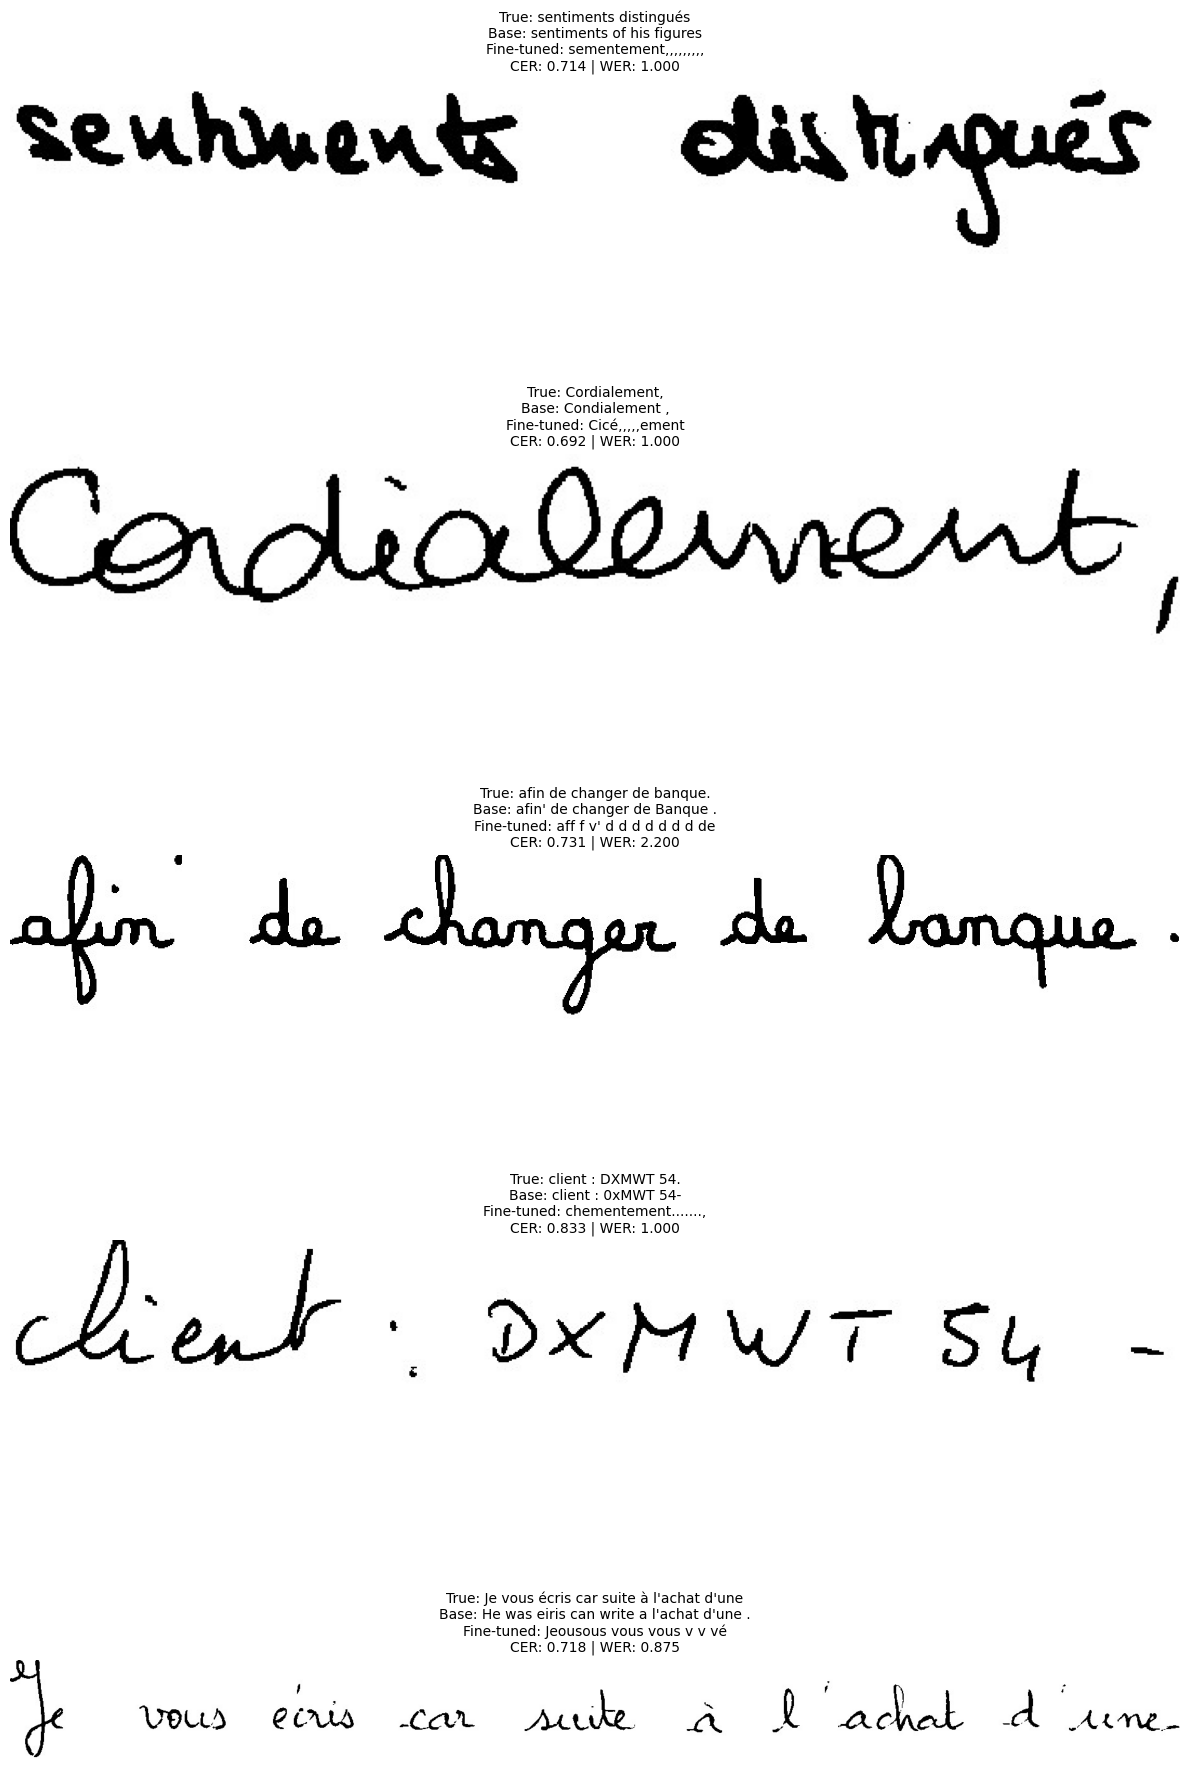

📊 Comparison Table:


,Image,True Text,Base Prediction,Fine-tuned Prediction,CER,WER
0,RIMES-2011-Lines\Images\train2011-540_000010.jpg,sentiments distingués,sentiments of his figures,"sementement,,,,,,,,,",0.714286,1.000
1,RIMES-2011-Lines\Images\train2011-410_000008.jpg,"Cordialement,","Condialement ,","Cicé,,,,,ement",0.692308,1.000
2,RIMES-2011-Lines\Images\train2011-1001_000004.jpg,afin de changer de banque.,afin' de changer de Banque .,aff f v' d d d d d d d de,0.730769,2.200
3,RIMES-2011-Lines\Images\train2011-964_000006.jpg,client : DXMWT 54.,client : 0xMWT 54-,"chementement.......,",0.833333,1.000
4,RIMES-2011-Lines\Images\train2011-862_000001.jpg,Je vous écris car suite à l'achat d'une,He was eiris can write a l'achat d'une .,Jeousous vous vous v v vé,0.717949,0.875



Average CER (Fine-tuned): 0.738
Average WER (Fine-tuned): 1.215


In [28]:
import torch
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
import matplotlib.pyplot as plt
from jiwer import wer, cer

# --- Reload models ---
base_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)
base_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

fine_model = VisionEncoderDecoderModel.from_pretrained("./trocr-finetuned-rimes").to(device)
fine_processor = TrOCRProcessor.from_pretrained("./trocr-finetuned-rimes")

base_model.eval()
fine_model.eval()

# --- Helper function for inference ---
def predict_text(model, processor, image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return pred_text

# --- Evaluate a few random images ---
import random
sample_images = random.sample(dataset_list, 5)  # randomly pick 5 examples

results = []

for sample in sample_images:
    img_path = sample["image_path"]
    true_text = sample["text"]

    base_pred = predict_text(base_model, base_processor, img_path)
    fine_pred = predict_text(fine_model, fine_processor, img_path)

    c = cer(true_text, fine_pred)
    w = wer(true_text, fine_pred)
    results.append((img_path, true_text, base_pred, fine_pred, c, w))

# --- Visual Comparison ---
fig, axes = plt.subplots(len(results), 1, figsize=(12, len(results)*4))
if len(results) == 1:
    axes = [axes]

for ax, (img_path, true_text, base_pred, fine_pred, c, w) in zip(axes, results):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        f"True: {true_text}\nBase: {base_pred}\nFine-tuned: {fine_pred}\nCER: {c:.3f} | WER: {w:.3f}",
        fontsize=10
    )

plt.tight_layout()
plt.show()

# --- Summary table ---
import pandas as pd
df_results = pd.DataFrame(results, columns=["Image", "True Text", "Base Prediction", "Fine-tuned Prediction", "CER", "WER"])
print("📊 Comparison Table:")
display(df_results)
print(f"\nAverage CER (Fine-tuned): {df_results['CER'].mean():.3f}")
print(f"Average WER (Fine-tuned): {df_results['WER'].mean():.3f}")



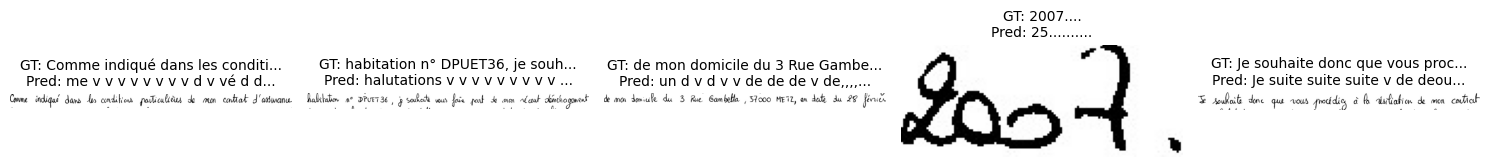

In [25]:
import matplotlib.pyplot as plt

model.eval()

def predict_text(image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return pred_text

# Pick 5 sample images
num_samples = 5
samples = dataset_list[:num_samples]

plt.figure(figsize=(15, 8))

for i, sample in enumerate(samples):
    img = Image.open(sample["image_path"]).convert("RGB")
    pred = predict_text(sample["image_path"])
    gt = sample["text"]

    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"GT: {gt[:30]}...\nPred: {pred[:30]}...", fontsize=10)

plt.tight_layout()
plt.show()


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [03:05<00:00,  9.30s/it]


📊 --- Model Comparison Summary ---
Base_CER: 0.2724
Fine_CER: 0.8376
Base_WER: 0.9418
Fine_WER: 1.0798
Base_BLEU: 0.0736
Fine_BLEU: 0.0070
Base_Acc: 0.0500
Fine_Acc: 0.0000



C:\Users\16466\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


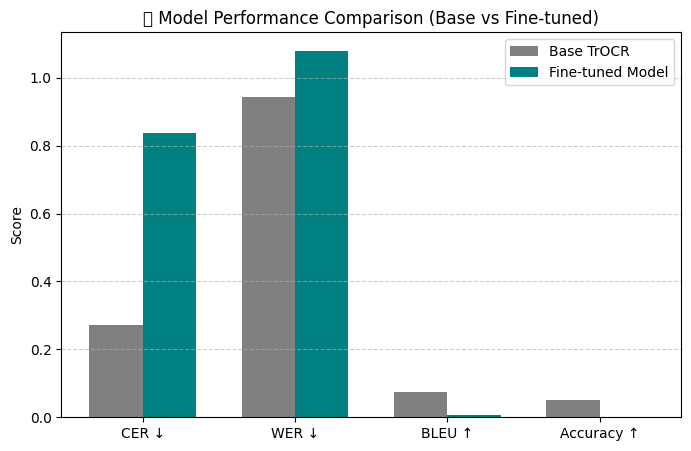

In [30]:
import torch
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
from PIL import Image
from jiwer import wer, cer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm

# --- Load models ---
device = "cuda" if torch.cuda.is_available() else "cpu"

base_model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to(device)
base_processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

fine_model = VisionEncoderDecoderModel.from_pretrained("./trocr-finetuned-rimes").to(device)
fine_processor = TrOCRProcessor.from_pretrained("./trocr-finetuned-rimes")

base_model.eval()
fine_model.eval()

# --- Helper: prediction function ---
def predict_text(model, processor, image_path):
    image = Image.open(image_path).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    return processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# --- Random subset for evaluation ---
sample_images = random.sample(dataset_list, 20)  # use 20 samples for comparison

metrics = {
    "Base_CER": [], "Fine_CER": [],
    "Base_WER": [], "Fine_WER": [],
    "Base_BLEU": [], "Fine_BLEU": [],
    "Base_Acc": [], "Fine_Acc": []
}

for sample in tqdm(sample_images, desc="Evaluating models"):
    img_path = sample["image_path"]
    true_text = sample["text"]

    # Base model prediction
    base_pred = predict_text(base_model, base_processor, img_path)
    fine_pred = predict_text(fine_model, fine_processor, img_path)

    # --- Compute metrics ---
    cc = SmoothingFunction()
    base_bleu = sentence_bleu([true_text.split()], base_pred.split(), smoothing_function=cc.method1)
    fine_bleu = sentence_bleu([true_text.split()], fine_pred.split(), smoothing_function=cc.method1)

    base_cer = cer(true_text, base_pred)
    fine_cer = cer(true_text, fine_pred)

    base_wer = wer(true_text, base_pred)
    fine_wer = wer(true_text, fine_pred)

    base_acc = int(base_pred.strip().lower() == true_text.strip().lower())
    fine_acc = int(fine_pred.strip().lower() == true_text.strip().lower())

    # Store
    metrics["Base_CER"].append(base_cer)
    metrics["Fine_CER"].append(fine_cer)
    metrics["Base_WER"].append(base_wer)
    metrics["Fine_WER"].append(fine_wer)
    metrics["Base_BLEU"].append(base_bleu)
    metrics["Fine_BLEU"].append(fine_bleu)
    metrics["Base_Acc"].append(base_acc)
    metrics["Fine_Acc"].append(fine_acc)

# --- Summarize ---
df_metrics = pd.DataFrame(metrics)
summary = df_metrics.mean().to_dict()

print("\n📊 --- Model Comparison Summary ---")
for k, v in summary.items():
    print(f"{k}: {v:.4f}")

# --- Plot comparison ---
labels = ["CER ↓", "WER ↓", "BLEU ↑", "Accuracy ↑"]
base_values = [
    summary["Base_CER"],
    summary["Base_WER"],
    summary["Base_BLEU"],
    summary["Base_Acc"],
]
fine_values = [
    summary["Fine_CER"],
    summary["Fine_WER"],
    summary["Fine_BLEU"],
    summary["Fine_Acc"],
]

x = range(len(labels))
plt.figure(figsize=(8, 5))
plt.bar(x, base_values, width=0.35, label="Base TrOCR", color="gray")
plt.bar([i + 0.35 for i in x], fine_values, width=0.35, label="Fine-tuned Model", color="teal")
plt.xticks([i + 0.175 for i in x], labels)
plt.ylabel("Score")
plt.title("📈 Model Performance Comparison (Base vs Fine-tuned)")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


What this does:

Compares 20 random samples from your RIMES dataset.

Computes:

CER → lower is better

WER → lower is better

BLEU → higher is better

Accuracy → higher is better

Displays both numeric and visual results.

Gives us a bar chart comparing the models on these metrics.